# Homework 1 - Introduction

In this module, I will build a prediction model to predict the duration of taxi rides in New York.


# 1. Downloading the data

Download the data from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page


In [1]:
import pyarrow.parquet as pq
import os
import pandas as pd
from NYC_TAXI.constants import DATA_FILE_PATH

data_folder_path = DATA_FILE_PATH#'data'
trips_df = pd.DataFrame()
 
for filename in os.listdir(data_folder_path):
    if filename.__contains__('2023-01'):
        full_file_pth = os.path.join(data_folder_path,filename)
        train_data = pq.read_table(full_file_pth)
        train_data = train_data.to_pandas()

In [2]:
print(train_data.head())

   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:32:10   2023-01-01 00:40:36              1.0   
1         2  2023-01-01 00:55:08   2023-01-01 01:01:27              1.0   
2         2  2023-01-01 00:25:04   2023-01-01 00:37:49              1.0   
3         1  2023-01-01 00:03:48   2023-01-01 00:13:25              0.0   
4         2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.97         1.0                  N           161           141   
1           1.10         1.0                  N            43           237   
2           2.51         1.0                  N            48           238   
3           1.90         1.0                  N           138             7   
4           1.43         1.0                  N           107            79   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \


### Read the data for January. How many columns are there?

In [3]:
print(train_data.columns)
print(len(train_data.columns))

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')
19


The dataset has 19 columns.

# 2. Computing duration

Compute a duration variable. It should contain the duration of a ride in minutes.

In [4]:
from datetime import timedelta
train_data['duration'] = train_data['tpep_dropoff_datetime'] - train_data['tpep_pickup_datetime']
train_data['duration'] = train_data['duration'].dt.total_seconds()/60
print(train_data['duration'].head(10))

0     8.433333
1     6.316667
2    12.750000
3     9.616667
4    10.833333
5    12.300000
6    10.450000
7    22.733333
8    14.933333
9    10.900000
Name: duration, dtype: float64


### What's the standard deviation of the trips duration in January?

In [5]:
print(train_data['duration'].std())

42.59435124195458


# 3. Dropping outliers

Check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

In [6]:
print('Values of duration range from ',train_data['duration'].min(), ' to ',train_data['duration'].max())

Values of duration range from  -29.2  to  10029.183333333332


In [7]:
train_data_clean = train_data[(train_data['duration'] >= 1) & (train_data['duration'] <=60)]

### What fraction of the records left after you dropped the outliers?

In [8]:
print('# of records before cleaning:', len(train_data))
print('# of records after cleaning:', len(train_data_clean))
print('Percentage of records left after cleaning:', (len(train_data_clean)*100)/ len(train_data) ,"%")

# of records before cleaning: 3066766
# of records after cleaning: 3009173
Percentage of records left after cleaning: 98.1220282212598 %


# 4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

In [9]:
location_dict = train_data_clean[['PULocationID','DOLocationID']].astype(str).to_dict(orient='records')
location_dict[:5]

[{'PULocationID': '161', 'DOLocationID': '141'},
 {'PULocationID': '43', 'DOLocationID': '237'},
 {'PULocationID': '48', 'DOLocationID': '238'},
 {'PULocationID': '138', 'DOLocationID': '7'},
 {'PULocationID': '107', 'DOLocationID': '79'}]

In [10]:
from sklearn.feature_extraction import DictVectorizer
# Create a dictionary vectorizer
vectorizer = DictVectorizer(sparse=False)

# Fit and transform the text data
X_train   = vectorizer.fit_transform(location_dict)

In [11]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (3009173, 515)


# 5. Training a model

- Train a plain linear regression model with default parameters, where duration is the response variable
- Calculate the RMSE of the model on the training data

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


target = 'duration'
y_train = train_data_clean[target].values

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

In [13]:
lr = LinearRegression()
# Training on a subset due to memory contraints
# max_ind = 100000
lr.fit(X_train[:max_ind], y_train[:max_ind])

y_pred = lr.predict(X_train[:max_ind])

print(f'Train RMSE: {mean_squared_error(y_train[:max_ind], y_pred, squared=False)}')

Train RMSE: 7.600619355603214


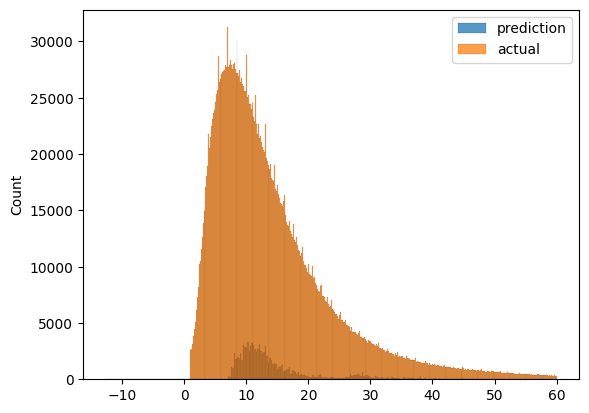

In [14]:
import seaborn as sns 
import matplotlib.pyplot as plt


sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

# 6. Evaluating the model

In [15]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [20]:
df_val = read_data(f'{DATA_FILE_PATH}/yellow_tripdata_2023-02.parquet')

In [21]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [23]:
X_val = vectorizer.transform(val_dicts) 
y_val = df_val.duration.values

In [24]:
X_val

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
y_pred = lr.predict(X_val)
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 39933334079.22792


# 6. Store DictVectorizer

- Store dv in the directory
- Store train,test datasets where January dataset is the training data, Feb the validation dataset and March the testing dataset

In [ ]:
import pickle
# Function to store python objects in pickle format
def dump_pickle(obj, filename: str):
    with open(filename, "wb") as f_out:
        return pickle.dump(obj, f_out)


In [ ]:
# Read data 
data_folder_path = 'data'
trips_df = pd.DataFrame()
 
for filename in os.listdir(data_folder_path):
    if filename.__contains__('2023-01'):
        full_file_pth = os.path.join(data_folder_path,filename)
        train_data = pq.read_table(full_file_pth)
        train_data = train_data.to_pandas()